# Country Wise Modelling - Seperate Project to Kaggle Kernel

## TO DO
1. Merge with COVID API DATA project to create end-end project.
2. Adapt for Kaggle Challenge.
3. Modify Plot function to have lockdown as optional argument.

### A. Using Kaggle Challenge Dataset 
Stored Locally.

In [456]:
path_train = 'covid19-global-forecasting-week-4/train.csv'
path_test = 'covid19-global-forecasting-week-4/test.csv'

In [457]:
df_train_count = pd.read_csv(path_train)
df_test_count = pd.read_csv(path_test)
df_train_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)
df_test_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)

#### Helper Functions

#### 1. To filter DataFrame according to Country.

In [160]:
def country_df(country, df):
    """Filters a Dataframe according to Country.
    Args: 
    country: String. Name of country for which dataframe is to be filtered for.
    df: Dataframe. The Dataframe that is to be filtered.
    Returns: 
    df_cases: Dataframe. Filtered dataframe containing fields with confirmed Covid cases for the country.
    df_fatal: Dataframe. Filtered dataframe containing fileds with Covid fatalities for the country.
    """
    if country != 'World':
        country_filt = (df['Country/Region'] == country)
        df_cases = df.loc[country_filt].groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.loc[country_filt].groupby(['Date'])['Fatalities'].sum()
    else:
        df_cases = df.groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.groupby(['Date'])['Fatalities'].sum()
    
    return df_cases, df_fatal

#### 2. To Prepare Model Train data.

In [161]:
def prepare_train_data(df_cases, df_fatal):
    """Splits ConfirmedCases and Fatalities dataframe into training features and labels.
    Args:
    df_cases: Dataframe. Filtered dataframe containing fields with confirmed Covid cases for the country.
    df_fatal: Dataframe. Filtered dataframe containing fileds with Covid fatalities for the country.
    Returns:
    x_train: np array. Array of integers denoting days since firstday of original df for model training features.
    y_cases: List. List of Confirmed Cases as labels for model from first day of original df.
    y_fatal: List. List of Fatalities as labels for model from first day of original df.
    """
    x_train = np.arange(0, len(df_cases)).reshape(-1,1)
    y_cases = df_cases.to_list()
    y_fatal = df_fatal.to_list()
   
    
    return x_train, y_cases, y_fatal


#### 3. For Plotting Actual and Predicted Metrics after modelling.

In [459]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from matplotlib import dates as dt
import datetime

def plot_actual_predicted(country, lockdown_date_str,  y_cases, y_pred, cases = True ):
    """Plots the Actual and Predicted ConfirmedCases/Fatalities for a country.
    Args:
    Returns:
    """
    if (cases):
        label = 'Confirmed Cases'
    else:
        label = 'Fatalities'
        
    xtick_locator = AutoDateLocator()
    xtick_formatter = AutoDateFormatter(xtick_locator)
    
    # generating dates using pandas, can be used with date_plot.
    train_times = pd.date_range(start = '2020-01-22', periods=len(y_cases))
    test_times = pd.date_range(start = '2020-01-22', periods=len(y_pred))
    dates = train_times.to_series().dt.date
    dates_test = test_times.to_series().dt.date

    # converting to Series, list 
    d_train = dates.tolist()
    d_test  = dates_test.tolist()
    
    # getting date_format variable for matplotlib and lockdown date.
    date_format = dt.DateFormatter('%b, %d')
    
    # converting lockdown date string to datetime.
    lockdown_date = datetime.datetime.strptime(lockdown_date_str, '%Y-%m-%d')
    
    plt.style.use('seaborn')
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(17)
    fig.autofmt_xdate()
    ax.plot_date(d_train , y_cases, label = 'Actual Values', linestyle = 'solid', marker = None)
    ax.plot_date(d_test , y_pred , label = 'Predicted Values', linestyle = 'solid', marker = None)
    ax.set_title(f'{country} : {label} - Polynomial Regression (Degree = 6)')
    ax.set_ylabel(f'No of {label}')
    ax.axvline(lockdown_date, color = 'r', label='Lockdown')
    ax.xaxis.set_major_formatter(date_format)
    ax.legend()
    fig.savefig(f'{country}_conf_case.jpg')

### Modeling - Polynomial Regression (Not good/complete - No Cross Validation etc.)

In [163]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [373]:
Input = [('poly', PolynomialFeatures(degree= 6)), ('lin_reg', LinearRegression())]

pipe = Pipeline(Input)

## India

#### Preparing Data 

In [427]:
# Filtering Dataset for India
india_cases_train, india_fatal_train = country_df('India', df_train_count)

# Preparing training and predict data.
x_train, y_cases, y_fatal = prepare_train_data(india_cases_train, india_fatal_train)

#x_test = np.arange(85).reshape(-1,1)

In [428]:
## Splitting into Train - Test sets
## 80 % Train, 20 % Test 

x_train_model = x_train[:65] 
y_train = y_cases[:65]
x_test = x_train[65:] 
y_test = y_cases[65:]

In [450]:
from sklearn.preprocessing import PolynomialFeatures

print(x_train_model.shape)
PolynomialFeatures(degree=6).fit_transform(x_train_model).shape

(65, 1)


(65, 7)

#### Predicting Confirmed Cases

In [429]:
pipe.fit(x_train_model, y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=6, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [430]:
pipe.score(x_train_model, y_train)

0.9955583936114343

In [431]:
pipe.score(x_test, y_test)

0.8994294038897958

In [432]:
y_predicted = pipe.predict(x_train)

In [443]:
pipe.predict([[100]])

array([49940.74783454])

In [437]:
x_pred = np.arange(100).reshape(-1,1)

In [438]:
y_predicted = pipe.predict(x_pred)

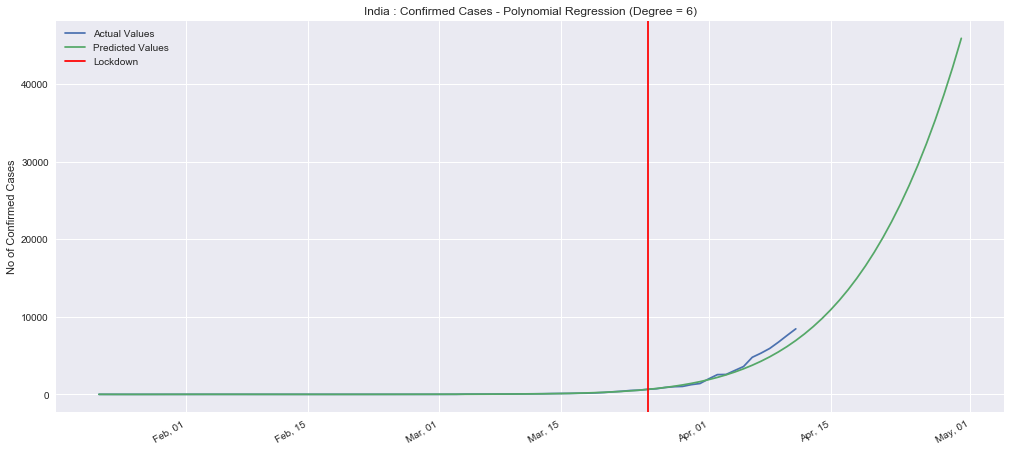

In [439]:
plot_actual_predicted('India', '2020-03-25', y_cases, y_predicted)

### Predicting Fatalities

In [381]:
# Getting labels for Fatalities
y_train = y_fatal[:65]
y_test = y_fatal[65:]

# fitting pipeline with fatalities

pipe.fit(x_train_model, y_train)

print(pipe.score(x_test, y_test))

# Predictions 

y_hat_fatal = pipe.predict(x_train)

0.8858853413257954


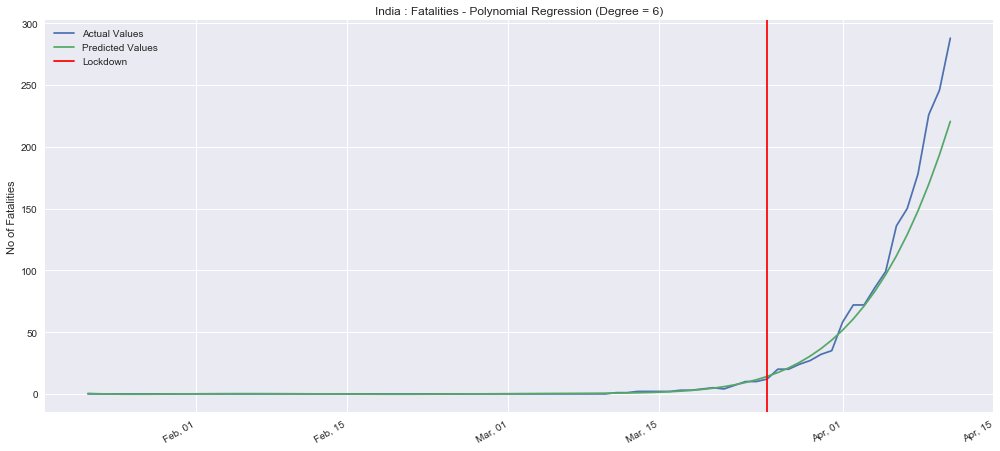

In [385]:
# Plotting these predictions

plot_actual_predicted('India', '2020-03-25', y_fatal, y_hat_fatal, cases = False)

### Growth Factor
<p>
    The growth factor on day N is the number of confirmed cases on day N minus confirmed cases on day N-1 divided by the number of confirmed cases on day N-1 minus confirmed cases on day N-2.
     <br>Measure of whether the disease is growing or not. </p>
1. A value of greater than 1 = growth. <br>
2. Less than 1 = decline. <br>
3. A growth factor of 1 is the inflection point and at this point the disease is not increasing.
<p>
It can be seen that the disease hasn't stabilised at the inflection point.<br>
The growth ratio on day N is the number of confirmed cases on day N divided by the number of confirmed cases on day N-1.</p>

#### Growth Factor In india

In [172]:
def growth_factor(confirmed):
    confirmed_nminus1 = confirmed.shift(1, axis = 0)
    confirmed_nminus2 = confirmed.shift(2, axis = 0)
    return ((confirmed - confirmed_nminus1)/(confirmed_nminus1 - confirmed_nminus2))

In [173]:
india_growth_factor = growth_factor(india_cases_train[41:])
print(india_growth_factor.mean())

2.0355819193388798


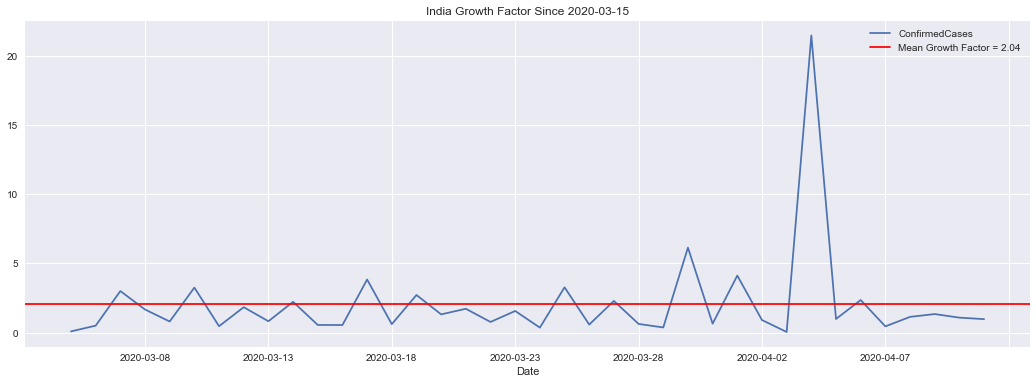

In [300]:
india_growth_factor.plot(grid = True, title = 'India Growth Factor Since 2020-03-15', figsize = (18,6))

plt.axhline(india_growth_factor.mean(), color = 'r', label='Mean Growth Factor = 2.04')
plt.legend()
plt.savefig('India_Growth_Factor')

#### Linear Regression for Growth Rate.

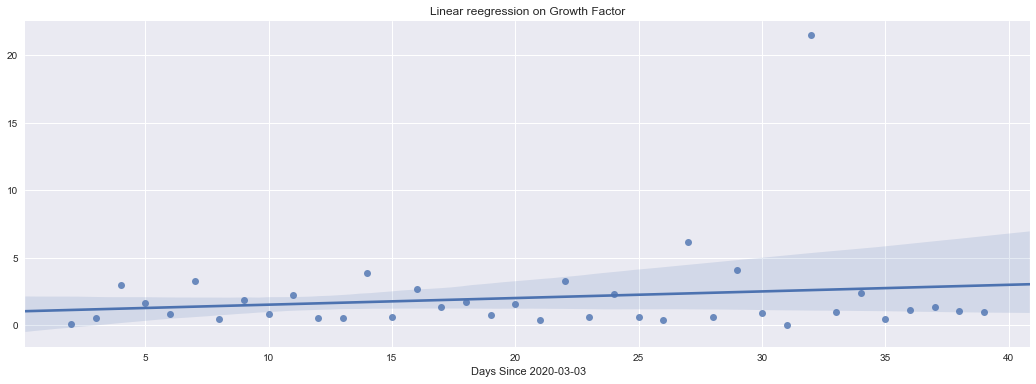

In [301]:
plt.figure(figsize = (18,6))
ax = sns.regplot(x = np.arange(len(india_growth_factor.index.tolist())) , y =india_growth_factor.to_list())
ax.set_title('Linear reegression on Growth Factor')
ax.set_xlabel(' Days Since 2020-03-03')
plt.savefig('India_Growth_Factor_Pred')
#ax.set_ybound(upper = 10)
# there is an outlier, causing problems (can just remove.)
# This is just a visualisation library, won't give you the equation, use plain linear reg to get line and plot it.

In [ ]:
# Growth of virus Has not stopped.

#### Growth Ratio of Covid 19 In India

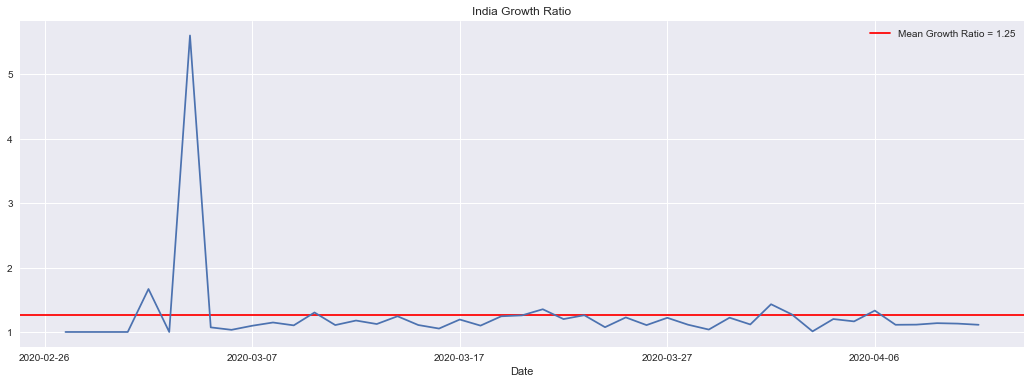

In [302]:
growth_ratio_india = india_cases_train.iloc[35:]/india_cases_train.iloc[35:].shift(1)

plt.axhline(growth_ratio_india.mean(), color = 'r', label='Mean Growth Ratio = 1.25')
plt.legend()

growth_ratio_india.plot(grid = True, title = 'India Growth Ratio', figsize = (18,6))
plt.savefig('India_Growth_Ratio')

### America

In [413]:
# getting filtered dataframes

us_cases, us_fatal = country_df('US', df_train_count)

# Preparing training and predict data.

x_train, y_case, y_fatal = prepare_train_data(us_cases, us_fatal)

# creating test data for 85 days.

x_test = np.arange(85).reshape(-1,1)

In [414]:
# Fitting polynomial reg pipeline for confirmed cases.

pipe.fit(x_train, y_case)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=6, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [421]:
# Getting Predictions

y_conf_pred = pipe.predict(x_test)

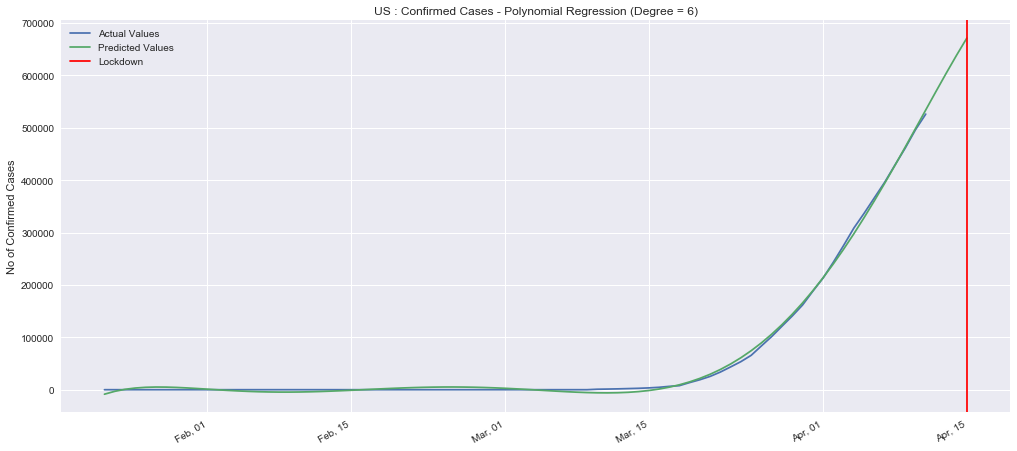

In [422]:
# Plotting these predictions 

plot_actual_predicted('US', '2020-04-15', y_case, y_conf_pred)

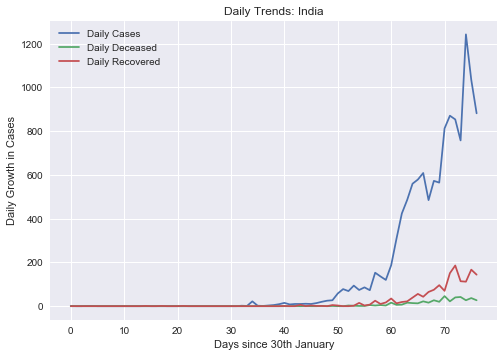

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


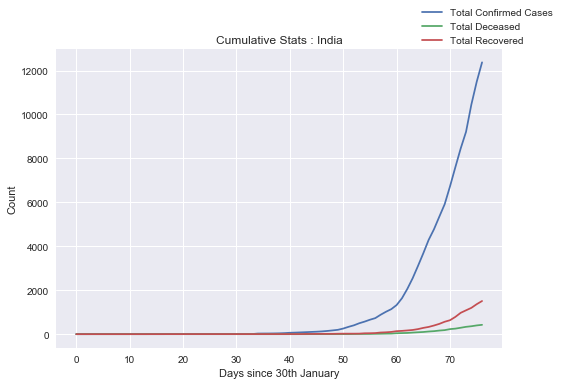

In [461]:
# Now plotting Daily Figures

plt.style.use('seaborn')
plt.title('Daily Trends: India')
plt.ylabel('Daily Growth in Cases')
plt.xlabel('Days since 30th January')
plt.plot(daily_conf, label='Daily Cases')
plt.plot(daily_dec, label='Daily Deceased')
plt.plot(daily_rec, label='Daily Recovered')
plt.legend()
plt.savefig('India_Daily_Stats.png')
plt.show()

# Now Lets plot Total Cases

total_conf = list_cases_stat(data, 'totalconfirmed')
total_dec = list_cases_stat(data, 'totaldeceased')
total_rec = list_cases_stat(data, 'totalrecovered')

fig, ax = plt.subplots()
ax.plot(total_conf, label='Total Confirmed Cases')
ax.plot(total_dec, label='Total Deceased')
ax.plot(total_rec, label='Total Recovered')
ax.set_title('Cumulative Stats : India')
ax.set_xlabel('Days since 30th January')
ax.set_ylabel('Count')
fig.legend()
fig.savefig('India_Cumulative_stats.png')
fig.show()